# Correlation coefficients

In chapter 3.5, we introduced the covariance of x and y and the correlation coefficient as measures of the dependence of the two variables on each other. In this section, we'll extend our discussion to the interpretation of the sample correlation coefficient.

Given two data sets of equal size $N$, {$x_i$} and {$y_i$}, Pearson's sample correlation coefficient is

$$r = \frac{\sum_{i=1}^{N}(x_i-\bar{x})(y_i-\bar{y})}{\sqrt{\sum_{i=1}^{N}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{N}(y_i-\bar{y})^2}}$$

with $ −1 \leq r \leq 1$. For uncorrelated variables, $r = 0$. If the pairs ($x_i$, $y_i$) are drawn from two uncorrelated univariate Gaussian distributions (i.e., the population correlation coefficient $\rho = 0$), then the distribution of $r$ follows Student’s t distribution with $k = N − 2$ degrees of freedom and

$$ t = r\sqrt{\frac{N-2}{1-r^2}} $$


Given this known distribution, a measured value of $r$ can be transformed into the significance of the statement that {$x_i$} and {$y_i$} are correlated. For example, if $N=10$, the probability that a value of $r$ as large as 0.72 would arise by chance is 1% (the one-sided 99% confidence level for Student’s t distribution with $k = 8$ degrees of freedom is $t=2.896$). We shall return to such an analysis in §4.6 on hypothesis testing.

When the sample is drawn from a bivariate Gaussian distribution with a nonvanishing population correlation coefficient $\rho$, the Fisher transformation can be used to estimate the confidence interval for $\rho$ from the measured value $r$. The distribution of $F$,

$$ F(r)= \frac{1}{2}\ln \bigg(\frac{1+r}{1-r}\bigg) $$

approximately follows a Gaussian distribution with the mean $\mu_F = F(\rho)$ and a standard deviation $ \sigma_F = (N-3)^{-1/2}$ 

. For the above sample with N = 10 and r = 0.72, this approximate approach ives a significance level of 0.8% when ρ = 0 (instead of the exact value of 1%).
σF = (N − 3)

Pearson’s correlation coefficient has two main deficiencies. First, the measurement errors for {xi} and {yi} are not used. As they become very large, the significance of any given value of r will decrease (if errors are much larger than the actual ranges of data values, the evidence for correlation vanishes). The case of nonnegligible errors is discussed in chapter 8. Second, Pearson’s correlation coefficient is sensitive to Gaussian outliers (recall the discussion in the previous section) and, more generally, the distribution of r does not follow Student’s t distribution if {xi} and {yi} are not drawn from a bivariate Gaussian distribution. In such cases, nonparametric correlation tests, discussed next, are a better option.

$$ \sum_{i=1}^N R_i = \frac{N(N+1)}{2} $$

$$ \sum_{i=1}^N (R_i)^2 = \frac{N(N+1)(2N+1)}{6} $$

$$ r_S = \frac{\sum_{i=1}^N (R_i^x -\overline{R^x})(R_i^y - \overline{R^y})}{\sqrt{\sum_{i=1}^N (R_i^x) - \overline{R^x})^2} \sqrt{\sum_{i=1}^N (R_i^y) - \overline{R^y})^2 }} $$

$$r_S = 1 - \frac{6}{N(N^2-1)} \sum_{i=1}^N (R_i^x - R_i^y)^2 $$

$$\tau = 2\frac{N_c - N_d}{N(N-1)} $$

$$ \sigma_\tau = \bigg[\frac{2(2N+5)}{9N(N-1)}\bigg]^{1/2} $$

$$ \overline{\tau} = \frac{2}{\pi}sin^{-1}(\rho) $$

First we will define the our parameters for the distributions.

In [3]:
Nbootstraps = 5000
N = 1000

sigma1 = 2.0
sigma2 = 1.0
mu = (10.0, 10.0)
alpha_deg = 45.0
alpha = alpha_deg * np.pi / 180
f = 0.01

Next we will create our sample of the distribution with and without outliers. We get rho_true from pearson/spearman r and tau_true from Eq. 41 of arXiv:1011.2009

In [11]:
np.random.seed(0)
X = bivariate_normal(mu, sigma1, sigma2, alpha, N)

X_out = X.copy()
X_out[:int(f * N)] = bivariate_normal(mu, 2, 5,
                                      45 * np.pi / 180., int(f * N))

rho_true = 0.6
tau_true = 2 / np.pi * np.arcsin(rho_true)

Next we create a function to compute the statistics.  Since this takes a while, we'll use the "pickle_results" decorator to save the results of the computation to disk.

In [20]:
@pickle_results('fig_correlations_dump.pkl')
def compute_results(N, Nbootstraps):
    results = np.zeros((3, 2, Nbootstraps))

    for k in range(Nbootstraps):
        ind = np.random.randint(N, size=N)
        for j, data in enumerate([X, X_out]):
            x = data[ind, 0]
            y = data[ind, 1]
            for i, statistic in enumerate([stats.pearsonr,
                                           stats.spearmanr,
                                           stats.kendalltau]):
                results[i, j, k] = statistic(x, y)[0]

    return results

results = compute_results(N, Nbootstraps)

@pickle_results: using precomputed results from 'fig_correlations_dump.pkl'


Next, we will plot the results

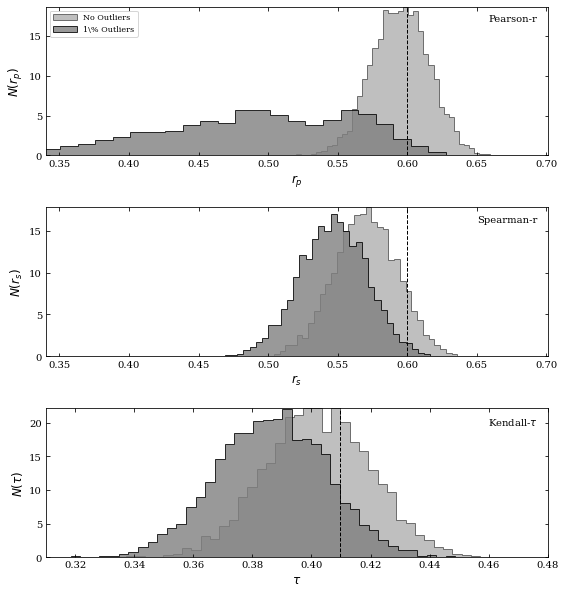

In [35]:
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(bottom=0.1, top=0.95, hspace=0.35)

histargs = (dict(alpha=0.5, label='No Outliers'),
            dict(alpha=0.8, label='%i%s Outliers' % (int(f * 100), pct)))

distributions = ['Pearson-r', 'Spearman-r', r'Kendall-$\tau$']
xlabels = ['r_p', 'r_s', r'\tau']\

for i in range(3):
    ax = fig.add_subplot(311 + i)
    for j in range(2):
        ax.hist(results[i, j], 40, histtype='stepfilled', fc='gray',
                density=True, **histargs[j])

    if i == 0:
        ax.legend(loc=2)

    ylim = ax.get_ylim()
    if i < 2:
        ax.plot([rho_true, rho_true], ylim, '--k', lw=1)
        ax.set_xlim(0.34, 0.701)
    else:
        ax.plot([tau_true, tau_true], ylim, '--k', lw=1)
        ax.set_xlim(0.31, 0.48)
    ax.set_ylim(ylim)

    ax.text(0.98, 0.95, distributions[i], ha='right', va='top',
            transform=ax.transAxes,fontsize = 10)

    ax.set_xlabel('$%s$' % xlabels[i], fontsize = 12)
    ax.set_ylabel('$N(%s)$' % xlabels[i],fontsize = 12)
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.show()

$$ H(y|x_0) = \frac{\int_{- \infty}^{y} h(x_o,y\prime)dy\prime} {\int_{- \infty}^{\infty} h(x_o,y\prime)dy\prime}$$

$$ x = \mu_x +\eta_1 \sigma_1 \cos\alpha - \eta_2\sigma_2 \sin \alpha $$

$$ y = \mu_y +\eta_1 \sigma_1 \sin\alpha - \eta_2\sigma_2 \cos \alpha $$

## Random Number Generation for arbitrary distributions

Often times in statistics, simulations of measurements are necessary to understand selection effects and resulting biases. These approaches are often called Monte Carlo simulations and the resulting mock samples can substitute for real measurements. 

Monte Carlo simulations require samples drawn from specified distribution functions -- the simplest case is the uniform distribution function. For example,`numpy.random.rand` defaults to drawing a random floating point number from a unfirom distribution over [0,1] (however, if more parameters need to be defined, we can use `numpy.random.uniform` as well). The `random` submodule of `NumPy` provides a myriad of useful functions that are worth looking into.

/var/folders/0b/q0wjgd1j7_l833v81gbxgbzh0000gn/T/ipykernel_37832/1022624949.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x = np.hstack((d.rvs(int(f * Ndata)) for d, f in zip(dists, fracs)))


KS test: D = 0.0028; p = 1


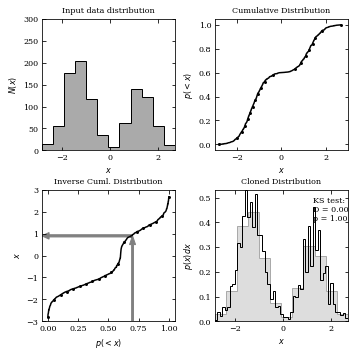

In [2]:
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats, interpolate
from astropy.visualization import hist
from astroML.density_estimation import EmpiricalDistribution

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Create a distribution and clone it
Ndata = 1000
Nclone = 100000
np.random.seed(0)

# generate an 'observed' bimodal distribution with 10000 values
dists = (stats.norm(-1.3, 0.5), stats.norm(1.3, 0.5))
fracs = (0.6, 0.4)
x = np.hstack((d.rvs(int(f * Ndata)) for d, f in zip(dists, fracs)))

# We can clone the distribution easily with this function
x_cloned = EmpiricalDistribution(x).rvs(Nclone)

# compute the KS test to check if they're the same
D, p = stats.ks_2samp(x, x_cloned)
print("KS test: D = %.2g; p = %.2g" % (D, p))

#------------------------------------------------------------
# For the sake of this example, we need to calculate some
#  of the partial steps used by EmpiricalDistribution

# create a cumulative distribution
x.sort()
Px_cuml = np.linspace(0, 1, Ndata)

# set up an interpolation of the inverse cumulative distribution
tck = interpolate.splrep(Px_cuml, x)

# sample evenly along the cumulative distribution, and interpolate
Px_cuml_sample = np.linspace(0, 1, 10 * Ndata)
x_sample = interpolate.splev(Px_cuml_sample, tck)

#------------------------------------------------------------
# Plot the cloned distribution and the procedure for obtaining it
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0.3, left=0.1, right=0.95,
                    bottom=0.08, top=0.92, wspace=0.3)

indices = np.linspace(0, Ndata - 1, 20).astype(int)

# plot a histogram of the input
ax = fig.add_subplot(221)
hist(x, bins='knuth', ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_ylim(0, 300)
ax.set_title('Input data distribution')
ax.set_xlabel('$x$')
ax.set_ylabel('$N(x)$')

# plot the cumulative distribution
ax = fig.add_subplot(222)
ax.scatter(x[indices], Px_cuml[indices], lw=0, c='k', s=9)
ax.plot(x, Px_cuml, '-k')
ax.set_xlim(-3, 3)
ax.set_ylim(-0.05, 1.05)
ax.set_title('Cumulative Distribution')
ax.set_xlabel('$x$')
ax.set_ylabel('$p(<x)$')

# plot the inverse cumulative distribution and spline fit
ax = fig.add_subplot(223)
ax.scatter(Px_cuml[indices], x[indices], lw=0, c='k', s=9)
ax.plot(Px_cuml_sample, x_sample, '-k')
ax.arrow(0.7, -3, 0, 3.5, width=0.015, fc='gray', ec='gray',
         head_width=0.05, head_length=0.4)
ax.arrow(0.7, 0.9, -0.69, 0, width=0.1, fc='gray', ec='gray',
         head_width=0.3, head_length=0.06)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-3, 3)
ax.set_title('Inverse Cuml. Distribution')
ax.set_xlabel('$p(<x)$')
ax.set_ylabel('$x$')

# plot the resulting cloned distribution
ax = fig.add_subplot(224)
hist(x, bins='knuth', ax=ax,
     histtype='stepfilled', density=True,
     ec='#AAAAAA', fc='#DDDDDD',
     label='input data')
hist(x_cloned, bins='knuth', ax=ax,
     histtype='step', density=True,
     color='k', label='cloned data')
ax.set_title('Cloned Distribution')
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)dx$')
ax.text(0.74, 0.95, "KS test:\nD = %.2f\np = %.2f" % (D, p),
        ha='left', va='top', transform=ax.transAxes)

plt.show()